In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Questions

1. What are the top 3 and the bottom 3 states in terms of number of users?
2. What are the top 3 and the bottom 3 states in terms of user engagement? In which states users are using the product a lot/very little.
3. The first user who signed-up for each state. 
4. Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened next. 
5. How would you set up a test to check whether your model works well and is improving engagement?

In [2]:
#read data
data = pd.read_json("song.json")
for col in ['time_played', 'user_sign_up_date']:
    data[col] = pd.to_datetime(data[col])
print("data has shape: ", data.shape)
data.head()

data has shape:  (4000, 6)


,id,song_played,time_played,user_id,user_sign_up_date,user_state
0,GOQMMKSQQH,Hey Jude,2015-06-11 21:51:35,122,2015-05-16,Louisiana
1,HWKKBQKNWI,We Can Work It Out,2015-06-06 16:49:19,3,2015-05-01,Ohio
2,DKQSXVNJDH,Back In the U.S.S.R.,2015-06-14 02:11:29,35,2015-05-04,New Jersey
3,HLHRIDQTUW,P.s. I Love You,2015-06-08 12:26:10,126,2015-05-16,Illinois
4,SUKJCSBCYW,Sgt. Pepper's Lonely Hearts Club Band,2015-06-28 14:57:00,6,2015-05-01,New Jersey


In [3]:
#some summary about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
id                   4000 non-null object
song_played          4000 non-null object
time_played          4000 non-null datetime64[ns]
user_id              4000 non-null int64
user_sign_up_date    4000 non-null datetime64[ns]
user_state           4000 non-null object
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 187.6+ KB


In [4]:
#find null values
data.isnull().sum()

id                   0
song_played          0
time_played          0
user_id              0
user_sign_up_date    0
user_state           0
dtype: int64

**Q1. top 3 and bottom 3 states in terms of # of users**

In [5]:
#find out unique user_state first
print("There are {} unique states".format(len(data['user_state'].unique())))

There are 41 unique states


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

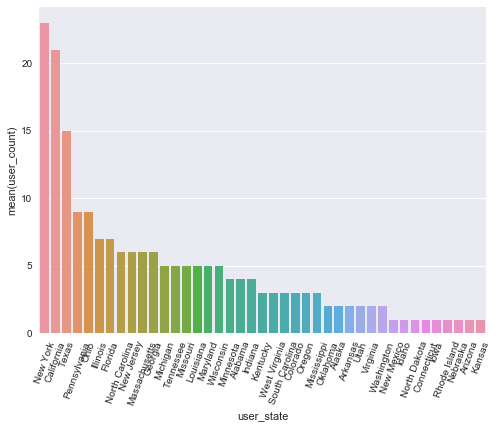

In [6]:
state_number = data.groupby(['user_state'])['user_id'].nunique().reset_index()
state_number = state_number.rename(columns = {'user_id':'user_count'})
state_number = state_number.sort_values(by = 'user_count', ascending=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,6))
sns.barplot(x = 'user_state', y = 'user_count', data= state_number, ax =ax)
plt.xticks(rotation = 70)

In [7]:
top_3 = state_number.head(3)
bottom_3 = state_number.tail(3)
print("Top 3 states are: ")
for i in top_3.index:
    print("{} is number {} in terms of number of users, and has {} users".format(state_number.user_state[i], \
                                                                                 i+1, state_number.user_count[i]))

print('\n'+"Bottom 3 states are:")
for i in bottom_3.index:
    print("{} is number {} in terms of least number of users, and has {} users".format(state_number.user_state[i]\
                                                                               , i+1, state_number.user_count[i]))

Top 3 states are: 
New York is number 26 in terms of number of users, and has 23 users
California is number 5 in terms of number of users, and has 21 users
Texas is number 36 in terms of number of users, and has 15 users

Bottom 3 states are:
Nebraska is number 23 in terms of least number of users, and has 1 users
Arizona is number 3 in terms of least number of users, and has 1 users
Kansas is number 14 in terms of least number of users, and has 1 users


**Q2. top 3 and bottom 3 states in terms of user engagement**

user engagement = total number of activities for each state / number of registed users in each state. Therefore, this could be something as *average number of songs played per user*

In [8]:
state_id = data.groupby(['user_state'])['id'].nunique().reset_index()
state_id = state_id.rename(columns = {"id": "total_number_of_songs_played"})
state_id['engagement'] = state_id['total_number_of_songs_played'] / state_number['user_count']
state_id = state_id.sort_values(by = 'engagement', ascending = False)

In [9]:
state_id.head(3)

,user_state,total_number_of_songs_played,engagement
22,Nebraska,36,36.000000
1,Alaska,58,29.000000
20,Mississippi,85,28.333333


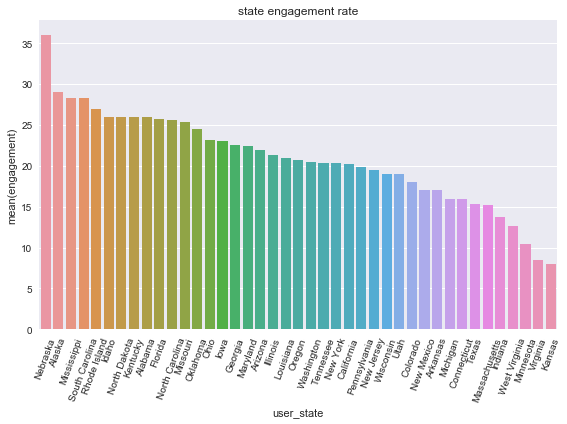

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x = 'user_state', y = 'engagement', data=state_id, ax= ax)
ax.set_title('state engagement rate')
plt.xticks(rotation = 70)
plt.tight_layout()

In [10]:
#top 3
state_id.head(3)

,user_state,total_number_of_songs_played,engagement
22,Nebraska,36,36.000000
1,Alaska,58,29.000000
20,Mississippi,85,28.333333


In [11]:
#bottom 3
state_id.tail(3)[::-1]

,user_state,total_number_of_songs_played,engagement
13,Kansas,8,8.0
37,Virginia,17,8.5
19,Minnesota,42,10.5


**Q3. The first user who signed-up for each state. **

In [12]:
first_user = data.groupby(['user_state', 'user_id'])['user_sign_up_date'].min().reset_index()
first_user_subset = first_user.groupby('user_state')['user_sign_up_date'].min().reset_index()
user_id = []
for state, date in zip(first_user_subset['user_state'], first_user_subset['user_sign_up_date']):
    idx = first_user.loc[(first_user['user_state'] == state) & (first_user['user_sign_up_date'] == date), 'user_id'].values
    if len(idx) == 1:
        user_id.append(idx[0])
    else:user_id.append(idx)
first_user_subset['first_user'] = user_id
first_user_subset.set_index('user_state', inplace = True)
first_user_subset = first_user_subset.sort_values(by = 'user_sign_up_date')

In [13]:
first_user_subset

,user_sign_up_date,first_user
user_state,,
Alabama,2015-05-01,5
Texas,2015-05-01,7
Oregon,2015-05-01,1
Ohio,2015-05-01,3
North Carolina,2015-05-01,2
New Mexico,2015-05-01,4
New Jersey,2015-05-01,6
Pennsylvania,2015-05-02,11
New York,2015-05-02,"[10, 12, 19, 22, 27]"


**Q4. Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened next**

1. Choose most popular song
2. Works like a language model. Find the total occurrences of two songs played 
3. Collaborative filtering. reference: https://github.com/JifuZhao/DS-Take-Home/blob/master/08.%20Song%20Challenge.ipynb

Language model like

In [15]:
import operator

def song_recommendation(dataframe, user_id, song_name):
    #get the subset of data first
    user_data = dataframe[dataframe['user_id'] == user_id].sort_values(by = \
                            'time_played')['song_played'].reset_index(drop = True)
    #count the number of times each one song after another, using a dict of dict
    song_count = dict()
    for i in range(len(user_data)):
        if user_data[i] not in song_count:
            song_count[user_data[i]] = {}
        if i != len(user_data) -1:
            song_count[user_data[i]][user_data[i+1]] = song_count[user_data[i]].get(user_data[i+1],0) + 1
    song_list = song_count[song_name]
    
    return max(song_list.items(), key = operator.itemgetter(1))[0]

#example, test user 122 with 'Revolution'
song_recommendation(data,122, 'Revolution')

'Get Back'

Collaborative filtering like <br\> Song similarity is calculated using number of users who listened to it. So we need to have a user-song matrix

In [16]:
data.head(3)

,id,song_played,time_played,user_id,user_sign_up_date,user_state
0,GOQMMKSQQH,Hey Jude,2015-06-11 21:51:35,122,2015-05-16,Louisiana
1,HWKKBQKNWI,We Can Work It Out,2015-06-06 16:49:19,3,2015-05-01,Ohio
2,DKQSXVNJDH,Back In the U.S.S.R.,2015-06-14 02:11:29,35,2015-05-04,New Jersey


In [25]:
#step 1. User song matrix
song_user = data.groupby(['song_played', 'user_id'])['id'].count().unstack(fill_value = 0)
song_user.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
song_played,,,,,,,,,,,,,,,,,,,,,
A Day In The Life,0,0,1,3,0,2,0,0,0,0,...,0,0,3,3,0,2,0,0,2,0
A Hard Day's Night,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
A Saturday Club Xmas/Crimble Medley,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ANYTIME AT ALL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Across The Universe,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#step 2. song-song similarity
from sklearn.preprocessing import normalize
song_user_norm = normalize(song_user, axis = 1)
similarity = np.dot(song_user_norm, song_user_norm.T)
song_song = pd.DataFrame(similarity, index = song_user.index, columns= song_user.index)
song_song.head(3)

song_played,A Day In The Life,A Hard Day's Night,A Saturday Club Xmas/Crimble Medley,ANYTIME AT ALL,Across The Universe,All My Loving,All You Need Is Love,And Your Bird Can Sing,BAD BOY,BALLAD OF JOHN AND YOKO,...,We Can Work It Out,When I'm 64,While My Guitar Gently Weeps,Wild Honey Pie,With a Little Help From My Friends,YOUR MOTHER SHOULD KNOW,Yellow Submarine,Yesterday,You Never Give Me Your Money,You're Going To Lose That Girl
song_played,,,,,,,,,,,,,,,,,,,,,
A Day In The Life,1.000000,0.235702,0.074536,0.119523,0.212132,0.355023,0.329404,0.152145,0.210819,0.172133,...,0.464938,0.030429,0.508964,0.223607,0.359092,0.037268,0.318198,0.353220,0.087841,0.0
A Hard Day's Night,0.235702,1.000000,0.000000,0.000000,0.100000,0.136931,0.111803,0.000000,0.000000,0.091287,...,0.259548,0.129099,0.210099,0.000000,0.000000,0.000000,0.050000,0.195468,0.074536,0.0
A Saturday Club Xmas/Crimble Medley,0.074536,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.109435,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [42]:
#step 3, top k most similar songs
def get_topk(song, df, k = 3):
    out = df.loc[song].sort_values(ascending = False)[1:k+1].reset_index()
    return out.rename(columns = {"song_played": "Song", song: 'Similarity'})

get_topk('Revolution', song_song)

,Song,Similarity
0,Come Together,0.680807
1,Get Back,0.660374
2,While My Guitar Gently Weeps,0.632051


**Q5. How would you set up a test to check whether your model works well and is improving
engagement?**

Using A/B testing with general procedure. Split groups, one with no recommendation, one with recommendation, and after collecting enough number of users, run t-test